In [1]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the pivot is performed flat toward the circle center
def is_flat_pivot(ball_of_foot, heel):
    """
    Determines if the pivot is performed flat by analyzing the relative position 
    of the ball of the foot and the heel. 
    A flat pivot condition is met if both the ball of the foot and heel remain at 
    approximately the same vertical position.
    """
    ball_x, ball_y = ball_of_foot
    heel_x, heel_y = heel

    # Flat pivot condition: minimal vertical difference between ball and heel
    return abs(ball_y - heel_y) < 0.01  # Small threshold to detect flat foot pivot

# Paths for the discus throwing videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage3/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage3/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints for pivot analysis (right foot)
                right_ball_of_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
                                      landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]
                right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].y]

                # Check if pivot is performed flat
                flat_pivot = is_flat_pivot(right_ball_of_foot, right_heel)

                # Store data for this frame with standard Python booleans and float conversion
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "flat_pivot": bool(flat_pivot),
                    "right_ball_of_foot": [float(coord) for coord in right_ball_of_foot],
                    "right_heel": [float(coord) for coord in right_heel]
                })

        # Release the video
        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Flat pivot analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737672596.318375 12323267 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737672596.372493 12323478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737672596.381376 12323476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737672596.393492 12323481 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Flat pivot analysis complete! JSON files saved in 'keypoints' folder.


In [3]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for flat pivot analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage3/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        
        with open(file_path, "r") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                print(f"Error loading JSON from {file}")
                continue

        # Ensure the data is a list
        if isinstance(data, list):
            pivot_data = [
                [int(frame.get("flat_pivot", 0))]  # Default to 0 if key is missing
                for frame in data if isinstance(frame, dict)
            ]
            sequences.append(pivot_data)
        else:
            print(f"Unexpected format in {file}, skipping.")

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
            labels.append(label)
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 15 sequences with labels.


In [4]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 75


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Debugging: Print shape before reshaping
print("Shape before reshaping - X_train:", np.array(X_train).shape)
print("Shape before reshaping - X_val:", np.array(X_val).shape)

# Dynamically infer number of features
num_features = np.array(X_train).shape[-1] if len(np.array(X_train).shape) > 2 else 1

# Ensure correct shape for LSTM input (samples, timesteps, features)
X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], num_features))
X_val = np.array(X_val).reshape((X_val.shape[0], X_val.shape[1], num_features))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of X_val: {X_val.shape}")


Shape before reshaping - X_train: (57, 113, 1)
Shape before reshaping - X_val: (18, 113, 1)
Training samples: 57, Validation samples: 18
Final shape of X_train: (57, 113, 1)
Final shape of X_val: (18, 113, 1)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print(model.summary())


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.2779 - mae: 0.3148 - val_loss: 0.2297 - val_mae: 0.3588
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.2823 - mae: 0.3949 - val_loss: 0.1816 - val_mae: 0.3639
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2212 - mae: 0.3896 - val_loss: 0.1615 - val_mae: 0.3713
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1949 - mae: 0.3794 - val_loss: 0.1606 - val_mae: 0.3757
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1719 - mae: 0.3745 - val_loss: 0.1588 - val_mae: 0.3712
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1783 - mae: 0.3930 - val_loss: 0.1620 - val_mae: 0.3732
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1698 - mae: 0.3703 - val_loss: 0.1731 - val_mae: 0.3697
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1641 - mae: 0.3548 - val_loss: 0.1835 - val_mae: 0.3760
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.196

In [8]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.0858, Validation MAE: 0.1498


In [9]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Predicted: 0.01, Actual: 0.00
Predicted: 0.43, Actual: 0.50
Predicted: 0.88, Actual: 1.00
Predicted: 0.01, Actual: 0.00
Predicted: 0.01, Actual: 0.00
Predicted: 1.14, Actual: 0.50
Predicted: 0.20, Actual: 0.50
Predicted: 0.03, Actual: 1.00
Predicted: 0.02, Actual: 0.00
Predicted: 0.44, Actual: 0.50
Predicted: 0.18, Actual: 0.00
Predicted: -0.00, Actual: 0.00
Predicted: 0.02, Actual: 0.00
Predicted: 0.80, Actual: 1.00
Predicted: 0.02, Actual: 0.00
Predicted: 0.96, Actual: 1.00
Predicted: 0.01, Actual: 0.00
Predicted: 0.01, Actual: 0.00


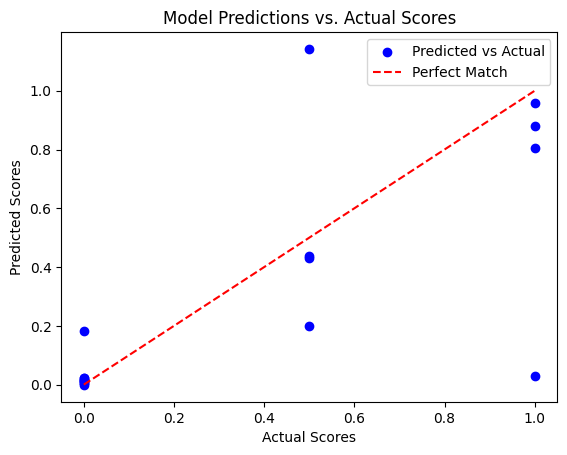

In [10]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [12]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Function to check if pivot is performed flat toward the circle center
def is_flat_pivot(ball_of_foot, heel):
    """
    Determines if the pivot is performed flat by analyzing the relative position 
    of the ball of the foot and the heel.
    """
    ball_x, ball_y = ball_of_foot
    heel_x, heel_y = heel

    # Flat pivot condition: minimal vertical displacement between ball and heel
    return abs(ball_y - heel_y) < 0.02

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage3/test_videos/1_user5.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for pivot analysis
        right_ball_of_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x, 
                              landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].x, 
                      landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].y]

        # Check for flat pivot
        flat_pivot = is_flat_pivot(right_ball_of_foot, right_heel)

        # Store only the right foot pivot status (to match the model's single feature expectation)
        new_keypoints.append([int(flat_pivot)])

cap.release()

# Ensure input shape matches the model's expectation
max_seq_length = 33  # Assuming the model expects 33 timesteps

# Pad sequence to match training input length
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Reshape to match model input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((1, max_seq_length, 1))

print(f"Input shape: {new_keypoints_padded.shape}")

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")


I0000 00:00:1737673025.164642 12323267 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737673025.272375 12367927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737673025.281742 12367927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Input shape: (1, 33, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Predicted Score: 0.02


In [13]:
print(X_train.shape[1])

113


In [17]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.75:
        return 1.0
    elif prediction >= 0.4:
        return 0.5
    else:
        return 0.0

In [18]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Classified: 0.0, Actual: 0.0
Classified: 0.5, Actual: 0.5
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 0.5
Classified: 0.0, Actual: 0.5
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.5, Actual: 0.5
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0


In [19]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [21]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Classification Accuracy: 0.83


In [22]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage3/models/discus_stage3.keras")